# Model Distribution Alignment Check

This notebook verifies that the simulation models (AR(1-5), Random Walk, Block Bootstrap) produce distributions that are statistically consistent with historical data.

**Methodology:**
1.  **Split Data:** 
    *   **Train:** 50 years of S&P 500 data (ending 10 years ago).
    *   **Test:** The most recent 10 years of data.
2.  **Calibrate:** Fit each model on the *Train* data.
3.  **Simulate:** Generate 5,000 Monte Carlo paths for the 10-year Test period using the calibrated models.
4.  **Build Actual Distribution:** Instead of comparing to a single scalar (the realized 10-year CAGR), we **bootstrap** the 10-year Test Data to create a distribution of "Actual" possibilities. This helps us compare the *regime* predicted by the model vs the *regime* that actually occurred.
5.  **Compare:** 
    *   **Blue:** Model Simulation Distribution (Trained on past 50y).
    *   **Orange:** Actual Test Distribution (Bootstrapped from last 10y).
    *   **Red Dashed Line:** The specific single realization of the last 10 years.

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from simulator import MeanRevertingMarket, RandomWalkMarket, BlockBootstrapMarket
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 1. Load and Split Data
try:
    df = pd.read_csv("s_and_p_500_with_dividends.csv", header=None, names=["Year", "Return"])
    df["Return"] = df["Return"] / 100.0
    df = df.sort_values("Year")
except FileNotFoundError:
    print("Error: Data file 's_and_p_500_with_dividends.csv' not found.")
    raise

# Define Split
test_len = 10
train_len = 50

# Ensure we have enough data
if len(df) < (test_len + train_len):
    raise ValueError("Not enough data for 50y Train + 10y Test split.")

test_df = df.iloc[-test_len:]
train_df = df.iloc[-(test_len + train_len):-test_len]
train_values = train_df["Return"].values

print(f"Train Set: {train_df['Year'].min()}-{train_df['Year'].max()} (n={len(train_df)})")
print(f"Test Set:  {test_df['Year'].min()}-{test_df['Year'].max()} (n={len(test_df)})")
print(f"Train Mean: {train_values.mean():.2%}, Vol: {train_values.std():.2%}")
print(f"Actual Test CAGR: {((1 + test_df['Return']).prod()**(1/test_len) - 1):.2%}")

Train Set: 1965-2014 (n=50)
Test Set:  2015-2024 (n=10)
Train Mean: 11.34%, Vol: 16.96%
Actual Test CAGR: 13.10%


In [7]:
# 2. Configure and Calibrate Models
models = {}

# AR(p) Models
for p in range(1, 6):
    model = MeanRevertingMarket(ar_order=p)
    model.calibrate_from_history(train_values)
    models[f'AR({p})'] = model

# Random Walk (fit on Train stats)
mu = np.mean(train_values)
residuals = train_values - mu
models['Random Walk'] = RandomWalkMarket(mu=mu, residuals=residuals)

# Block Bootstrap (resample Train history)
models['Block Bootstrap'] = BlockBootstrapMarket(history_returns=train_values, block_size=5)

In [8]:
# 3. Generate "Actual" Distribution (Bootstrapping Test Data)
n_paths = 5000
n_years_sim = len(test_df)

# We resample returns from the Test period to build a distribution 
# of what outcomes are possible under the "Test Regime".
np.random.seed(42)
test_returns = test_df["Return"].values
boot_matrix = np.random.choice(test_returns, size=(n_years_sim, n_paths))
actual_boot_cagrs = (np.prod(1 + boot_matrix, axis=0))**(1/n_years_sim) - 1

# Actual Single Realization
actual_cagr = (1 + test_df["Return"]).prod()**(1/n_years_sim) - 1

print(f"Bootstrapped Test Dist Mean: {actual_boot_cagrs.mean():.2%}")
print(f"Actual Single Realized CAGR: {actual_cagr:.2%}")

Bootstrapped Test Dist Mean: 13.27%
Actual Single Realized CAGR: 13.10%


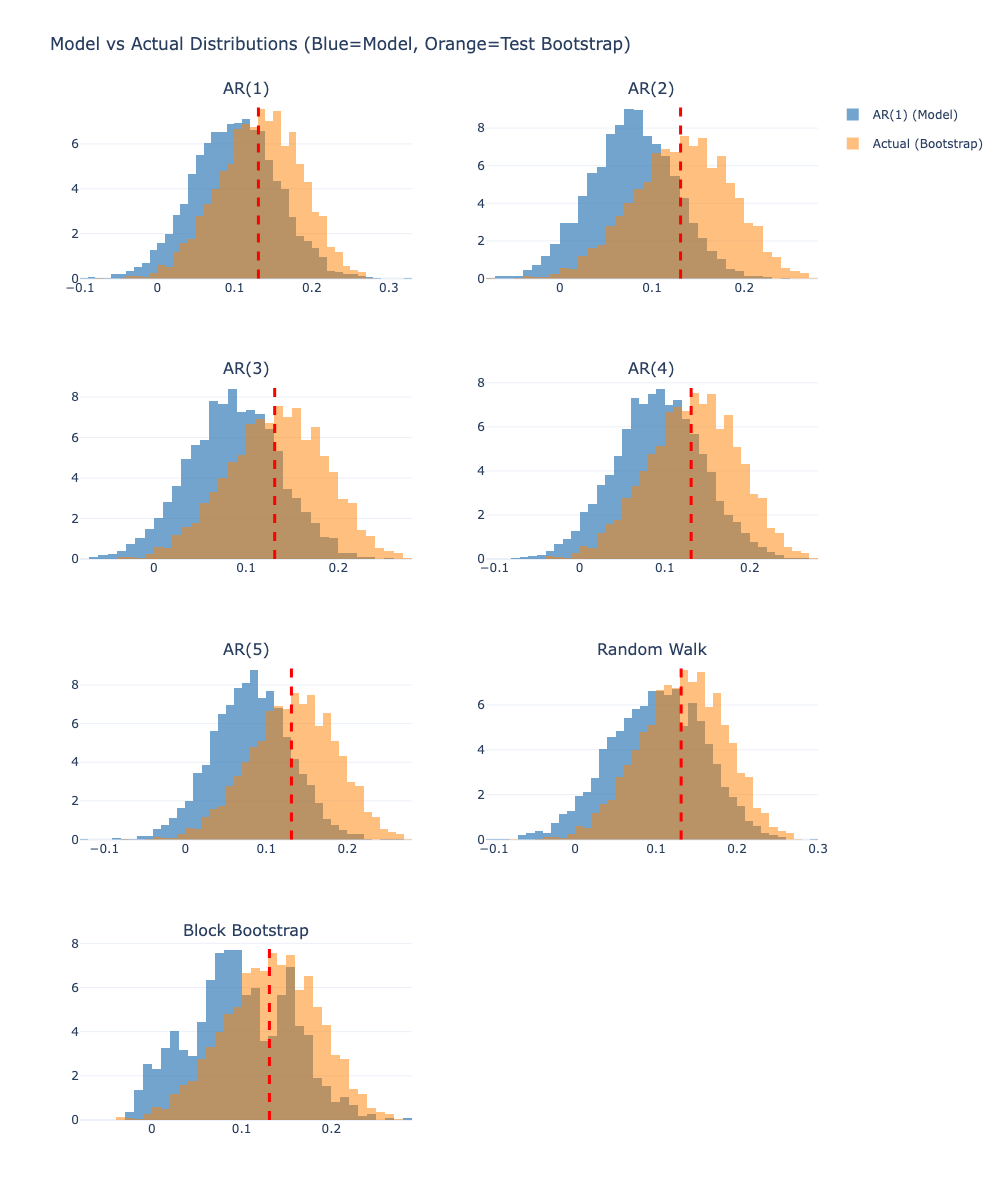

In [9]:
# 4. Run Simulation and Visualize
row_count = (len(models) + 1) // 2
fig = make_subplots(
    rows=row_count, cols=2,
    subplot_titles=list(models.keys()),
    vertical_spacing=0.1
)

row = 1
col = 1
results = {}

for name, model in models.items():
    # Simulate Matrix (years x paths)
    sim_matrix = model.simulate_matrix(years=n_years_sim, n_paths=n_paths)
    
    # Calculate CAGR for each path
    cum_growth = np.prod(1 + sim_matrix, axis=0)
    sim_cagrs = cum_growth**(1/n_years_sim) - 1
    
    # Statistics
    mean_sim = np.mean(sim_cagrs)
    
    # Measure Overlap / Alignment
    # Check if the mean of the Bootstrapped Test Dist falls within the central mass of the Model Dist
    lower_bound = np.percentile(sim_cagrs, 2.5)
    upper_bound = np.percentile(sim_cagrs, 97.5)
    boot_mean = np.mean(actual_boot_cagrs)
    is_aligned = lower_bound <= boot_mean <= upper_bound
    
    # --- PLOTTING ---
    
    # 1. Model Distribution (Blue)
    fig.add_trace(
        go.Histogram(
            x=sim_cagrs, 
            nbinsx=60, 
            name=f'{name} (Model)',
            showlegend=(row==1 and col==1),
            marker_color='rgba(55, 126, 184, 0.7)', # Blue
            histnorm='probability density',
            legendgroup='model'
        ),
        row=row, col=col
    )
    
    # 2. Actual Bootstrapped Distribution (Orange)
    fig.add_trace(
        go.Histogram(
            x=actual_boot_cagrs, 
            nbinsx=60, 
            name='Actual (Bootstrap)',
            showlegend=(row==1 and col==1),
            marker_color='rgba(255, 127, 0, 0.5)', # Orange Transparent
            histnorm='probability density',
            legendgroup='actual'
        ),
        row=row, col=col
    )
    
    # 3. Actual Realization Line (Red)
    fig.add_vline(
        x=actual_cagr, 
        line_width=3, 
        line_dash="dash", 
        line_color="red", 
        row=row, col=col
    )
    
    results[name] = {
        "Model Mean": mean_sim,
        "Test Boot Mean": boot_mean,
        "Overlap?": is_aligned
    }

    col += 1
    if col > 2:
        col = 1
        row += 1

fig.update_layout(
    height=1200, 
    width=950, 
    title_text="Model vs Actual Distributions (Blue=Model, Orange=Test Bootstrap)",
    template="plotly_white",
    barmode='overlay'
)

fig.show()

In [ ]:
# Summary Table
res_df = pd.DataFrame(results).T
res_df["Overlap?"] = res_df["Overlap?"].astype(bool)

def highlight_bool(val):
    color = 'lightgreen' if val else 'lightcoral'
    return f'background-color: {color}'

res_df.style.format("{:.2%}", subset=["Model Mean", "Test Boot Mean"]).map(highlight_bool, subset=["Overlap?"])